# 🎵 Understanding MFCC Step by Step
### From Raw Audio to Features

This notebook walks through the complete MFCC (Mel-Frequency Cepstral Coefficients) extraction process, processing a real audio file through each step with visualizations and explanations.

**Learning Goals:**
- Understand each transformation in the MFCC pipeline
- See how raw audio becomes machine learning features
- Learn both the technical details and intuitive explanations

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.fftpack import dct
import IPython.display as ipd

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Load Sample Audio

Let's start by loading a sample audio file. We'll use librosa's built-in example or a test audio file.

In [2]:
# Option 1: Load a sample audio file from librosa
try:
    # Try loading librosa's example audio
    audio_path = librosa.example('trumpet')
    signal, sample_rate = librosa.load(audio_path, sr=16000, duration=3.0)
    print(f"✅ Loaded librosa example: {audio_path}")
except:
    # Fallback: generate a synthetic audio signal
    print("📢 Generating synthetic audio signal...")
    sample_rate = 16000
    duration = 2.0
    t = np.linspace(0, duration, int(sample_rate * duration))
    
    # Mix of frequencies to simulate speech-like signal
    signal = (
        0.3 * np.sin(2 * np.pi * 200 * t) +
        0.2 * np.sin(2 * np.pi * 450 * t) +
        0.15 * np.sin(2 * np.pi * 800 * t) +
        0.1 * np.sin(2 * np.pi * 1500 * t) +
        0.05 * np.sin(2 * np.pi * 3000 * t) +
        0.03 * np.random.randn(len(t))
    )

print(f"\n📊 Audio Properties:")
print(f"   Sample Rate: {sample_rate} Hz")
print(f"   Duration: {len(signal)/sample_rate:.2f} seconds")
print(f"   Number of Samples: {len(signal):,}")
print(f"   Data Type: {signal.dtype}")

# Play the audio
print("\n🔊 Listen to the audio:")
ipd.Audio(signal, rate=sample_rate)

✅ Loaded librosa example: /Users/fred/Library/Caches/librosa/sorohanro_-_solo-trumpet-06.ogg

📊 Audio Properties:
   Sample Rate: 16000 Hz
   Duration: 3.00 seconds
   Number of Samples: 48,000
   Data Type: float32

🔊 Listen to the audio:


---
## Step 1: Raw Audio Waveform 🎵

### 📐 Technical Terms:
**Time-Domain Signal** - Amplitude values sampled at discrete time intervals (e.g., 16kHz = 16,000 samples per second)

### 👂 In Simple Terms:
This is what your microphone captures - air pressure changes over time. It's just numbers showing how much the speaker cone moves back and forth.

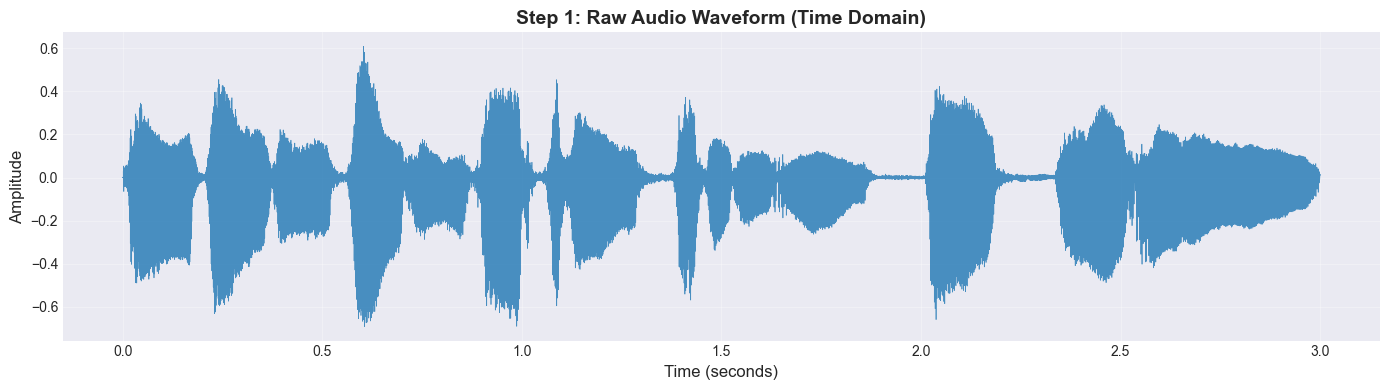

📝 Code equivalent:
import librosa
signal, sample_rate = librosa.load('audio.wav', sr=16000)
# signal is a numpy array of amplitude values


In [3]:
# Visualize the raw waveform
plt.figure(figsize=(14, 4))
time_axis = np.linspace(0, len(signal)/sample_rate, len(signal))
plt.plot(time_axis, signal, linewidth=0.5, alpha=0.8)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title('Step 1: Raw Audio Waveform (Time Domain)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📝 Code equivalent:")
print("""import librosa
signal, sample_rate = librosa.load('audio.wav', sr=16000)
# signal is a numpy array of amplitude values""")

---
## Step 2: Framing & Windowing 🪟

### 📐 Technical Terms:
- **Framing:** Dividing signal into overlapping segments (typically 20-40ms frames with 50% overlap)
- **Windowing:** Applying a window function (Hamming, Hann) to reduce spectral leakage at frame boundaries

### 👂 In Simple Terms:
Audio changes over time, so we chop it into small chunks (like 25ms snapshots). We smooth the edges of each chunk so they don't create artificial "clicks" when we analyze them.

📊 Framing Results:
   Frame length: 512 samples (~32.0ms)
   Hop length: 160 samples (~10.0ms)
   Number of frames: 297
   Frame shape: (297, 512)


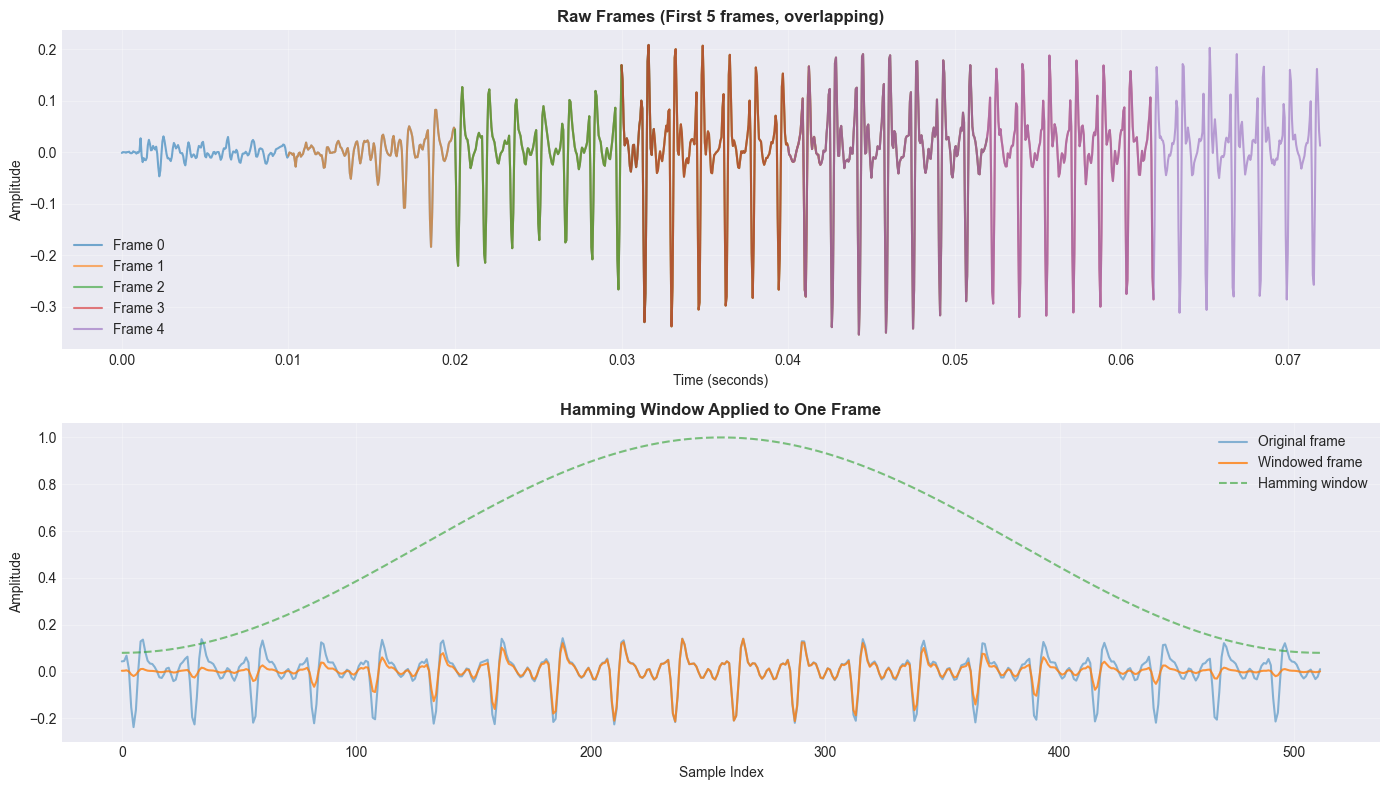


📝 Code equivalent:
# Pre-emphasis
emphasized = np.append(signal[0], signal[1:] - 0.97 * signal[:-1])

# Framing
frames = []
for i in range(0, len(emphasized) - frame_length, hop_length):
    frames.append(emphasized[i:i + frame_length])
frames = np.array(frames)

# Windowing
frames *= np.hamming(frame_length)


In [4]:
# Step 1: Pre-emphasis filter (boost high frequencies)
pre_emphasis = 0.97
emphasized = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

# Step 2: Framing with overlap
frame_length = 512  # ~32ms at 16kHz
hop_length = 160    # ~10ms at 16kHz (overlap)

frames = []
for i in range(0, len(emphasized) - frame_length, hop_length):
    frames.append(emphasized[i:i + frame_length])
frames = np.array(frames)

print(f"📊 Framing Results:")
print(f"   Frame length: {frame_length} samples (~{frame_length/sample_rate*1000:.1f}ms)")
print(f"   Hop length: {hop_length} samples (~{hop_length/sample_rate*1000:.1f}ms)")
print(f"   Number of frames: {len(frames)}")
print(f"   Frame shape: {frames.shape}")

# Step 3: Apply Hamming window to each frame
window = np.hamming(frame_length)
frames_windowed = frames * window

# Visualize frames and windowing
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Show individual frames
axes[0].set_title('Raw Frames (First 5 frames, overlapping)', fontsize=12, fontweight='bold')
for i in range(min(5, len(frames))):
    offset = i * hop_length
    time_frame = np.arange(offset, offset + frame_length) / sample_rate
    axes[0].plot(time_frame, frames[i], alpha=0.6, label=f'Frame {i}')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Show Hamming window effect
axes[1].set_title('Hamming Window Applied to One Frame', fontsize=12, fontweight='bold')
axes[1].plot(frames[10], alpha=0.5, label='Original frame')
axes[1].plot(frames_windowed[10], alpha=0.8, label='Windowed frame')
axes[1].plot(window, '--', alpha=0.6, label='Hamming window')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📝 Code equivalent:")
print("""# Pre-emphasis
emphasized = np.append(signal[0], signal[1:] - 0.97 * signal[:-1])

# Framing
frames = []
for i in range(0, len(emphasized) - frame_length, hop_length):
    frames.append(emphasized[i:i + frame_length])
frames = np.array(frames)

# Windowing
frames *= np.hamming(frame_length)""")

---
## Step 3: FFT → Power Spectrogram 📊

### 📐 Technical Terms:
- **FFT (Fast Fourier Transform):** Algorithm to convert time-domain signal to frequency-domain
- **Power Spectrum:** Magnitude squared of FFT output, representing energy at each frequency
- **Spectrogram:** Time-frequency representation showing how spectrum changes over time

### 👂 In Simple Terms:
We convert each time chunk into "which frequencies are present." Like a prism splits white light into colors, FFT splits audio into its frequency components. Dark = quiet, Bright = loud.

📊 FFT Results:
   FFT size: 512
   Magnitude frames shape: (297, 257)
   Power frames shape: (297, 257)
   Frequency bins: 257
   Frequency resolution: 31.2 Hz per bin


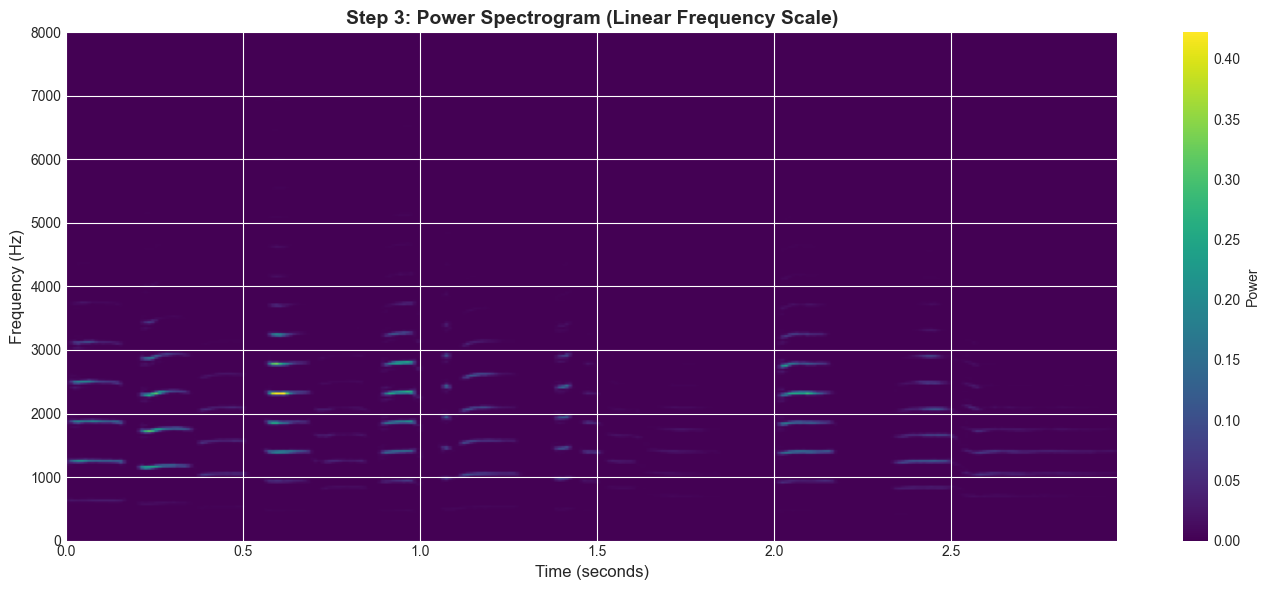


💡 Key Insight: Linear frequency scale - equal spacing from 0 to 8000 Hz. But humans don't hear this way!

📝 Code equivalent:
# Apply FFT
mag_frames = np.abs(np.fft.rfft(frames, fft_size))

# Calculate Power Spectrum
pow_frames = (mag_frames ** 2) / fft_size
# pow_frames shape: (num_frames, fft_size//2 + 1)


In [5]:
# Apply FFT to each frame
fft_size = 512
mag_frames = np.abs(np.fft.rfft(frames_windowed, fft_size))

# Calculate Power Spectrum
pow_frames = (mag_frames ** 2) / fft_size

print(f"📊 FFT Results:")
print(f"   FFT size: {fft_size}")
print(f"   Magnitude frames shape: {mag_frames.shape}")
print(f"   Power frames shape: {pow_frames.shape}")
print(f"   Frequency bins: {pow_frames.shape[1]}")
print(f"   Frequency resolution: {sample_rate/fft_size:.1f} Hz per bin")

# Visualize the power spectrogram
plt.figure(figsize=(14, 6))
plt.imshow(pow_frames.T, aspect='auto', origin='lower', cmap='viridis', 
           extent=[0, len(pow_frames)*hop_length/sample_rate, 0, sample_rate/2])
plt.colorbar(label='Power')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Frequency (Hz)', fontsize=12)
plt.title('Step 3: Power Spectrogram (Linear Frequency Scale)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Linear frequency scale - equal spacing from 0 to 8000 Hz. But humans don't hear this way!")

print("\n📝 Code equivalent:")
print("""# Apply FFT
mag_frames = np.abs(np.fft.rfft(frames, fft_size))

# Calculate Power Spectrum
pow_frames = (mag_frames ** 2) / fft_size
# pow_frames shape: (num_frames, fft_size//2 + 1)""")

---
## Step 4: Mel Filterbank - The Magic Step! 🎯

### 📐 Technical Terms:
- **Mel Scale:** Perceptual frequency scale where equal distances correspond to equal perceived pitch differences
- **Mel Filterbank:** Set of overlapping triangular filters spaced uniformly on the mel scale
- **Formula:** mel = 2595 × log₁₀(1 + Hz / 700)
- **Typical:** 40-128 mel bands covering 0-8000 Hz

### 👂 In Simple Terms:
Humans hear the difference between 100Hz and 200Hz easily (sounds very different!), but 5000Hz vs 5100Hz? Barely noticeable. The mel scale spaces frequencies like our ears actually hear them - more detail in low frequencies, less in high.

These triangular filters are like "buckets" that group nearby frequencies together. Low frequencies get narrow buckets (more detail), high frequencies get wide buckets (less detail).

📊 Mel Filterbank Properties:
   Number of filters: 40
   Frequency range: 0 - 8000.0 Hz
   Mel range: 0.0 - 2840.0 mel
   Filterbank shape: (40, 257)


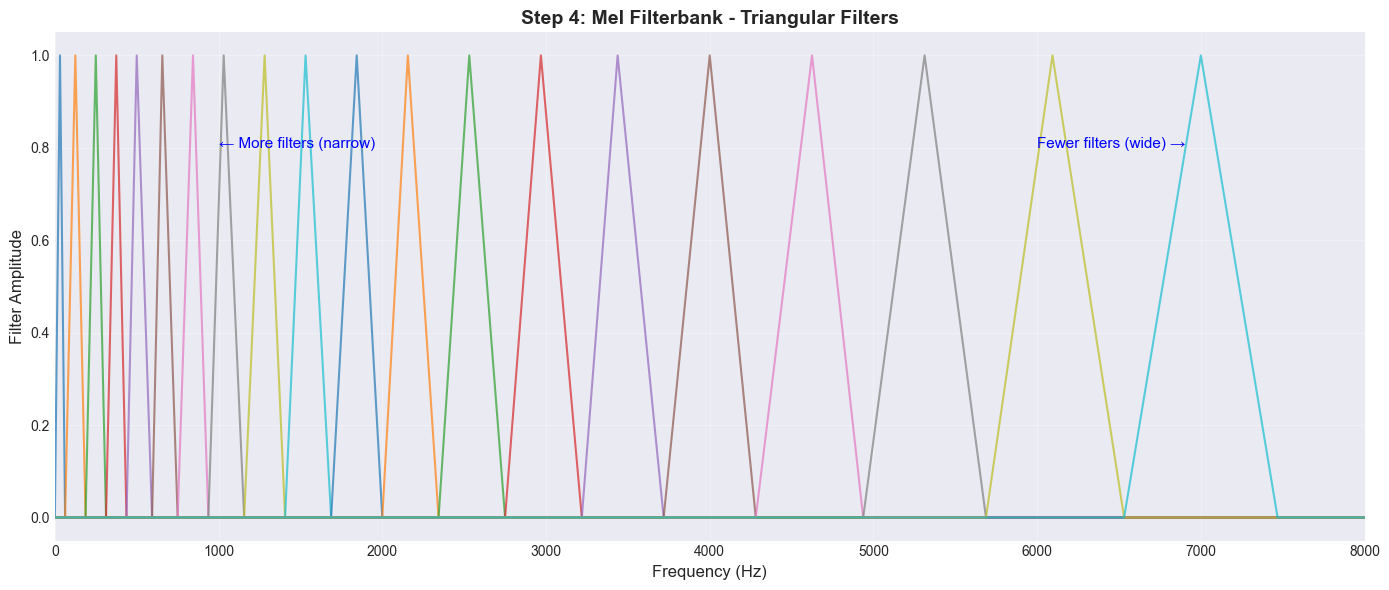


📊 After filtering:
   Mel spectrum shape: (297, 40)
   Reduced from 257 FFT bins to 40 mel bands

💡 The Mel Formula: mel = 2595 × log₁₀(1 + Hz/700)
   • 100 Hz → 150 mel
   • 200 Hz → 283 mel (133 mel difference)
   • 5000 Hz → 2363 mel
   • 5100 Hz → 2383 mel (20 mel difference) ← Same 100Hz, but perceptually different!


In [6]:
# Create Mel Filterbank
def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

n_filters = 40
low_freq = 0
high_freq = sample_rate / 2

# Create evenly spaced points in mel scale
low_mel = hz_to_mel(low_freq)
high_mel = hz_to_mel(high_freq)
mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
hz_points = mel_to_hz(mel_points)

# Convert to FFT bin numbers
bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)

# Create triangular filters
mel_filterbank = np.zeros((n_filters, fft_size // 2 + 1))
for i in range(n_filters):
    left, center, right = bin_points[i:i+3]
    # Rising slope
    mel_filterbank[i, left:center] = (np.arange(left, center) - left) / (center - left)
    # Falling slope
    mel_filterbank[i, center:right] = (right - np.arange(center, right)) / (right - center)

print(f"📊 Mel Filterbank Properties:")
print(f"   Number of filters: {n_filters}")
print(f"   Frequency range: {low_freq} - {high_freq} Hz")
print(f"   Mel range: {low_mel:.1f} - {high_mel:.1f} mel")
print(f"   Filterbank shape: {mel_filterbank.shape}")

# Visualize the mel filterbank
plt.figure(figsize=(14, 6))
freq_axis = np.linspace(0, sample_rate/2, mel_filterbank.shape[1])
for i in range(0, n_filters, 2):  # Plot every other filter for clarity
    plt.plot(freq_axis, mel_filterbank[i], alpha=0.7, linewidth=1.5)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Filter Amplitude', fontsize=12)
plt.title('Step 4: Mel Filterbank - Triangular Filters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim([0, sample_rate/2])
plt.text(1000, 0.8, '← More filters (narrow)', fontsize=11, color='blue')
plt.text(6000, 0.8, 'Fewer filters (wide) →', fontsize=11, color='blue')
plt.tight_layout()
plt.show()

# Apply filterbank to power spectrum
mel_spectrum = np.dot(pow_frames, mel_filterbank.T)

print(f"\n📊 After filtering:")
print(f"   Mel spectrum shape: {mel_spectrum.shape}")
print(f"   Reduced from {pow_frames.shape[1]} FFT bins to {mel_spectrum.shape[1]} mel bands")

print("\n💡 The Mel Formula: mel = 2595 × log₁₀(1 + Hz/700)")
print(f"   • 100 Hz → {hz_to_mel(100):.0f} mel")
print(f"   • 200 Hz → {hz_to_mel(200):.0f} mel ({hz_to_mel(200) - hz_to_mel(100):.0f} mel difference)")
print(f"   • 5000 Hz → {hz_to_mel(5000):.0f} mel")
print(f"   • 5100 Hz → {hz_to_mel(5100):.0f} mel ({hz_to_mel(5100) - hz_to_mel(5000):.0f} mel difference) ← Same 100Hz, but perceptually different!")

---
## Step 5: Mel Spectrogram (After Filtering) 🎨

### 📐 Technical Terms:
**Mel Spectrogram:** Time-frequency representation with perceptually-spaced frequency bands. Result of applying mel filterbank to power spectrum - reduces dimensionality from ~257 FFT bins to ~40 mel bands.

### 👂 In Simple Terms:
Now instead of thousands of frequency bins, we have ~40 mel bands that match how humans actually perceive sound. This is a more "ear-friendly" representation.

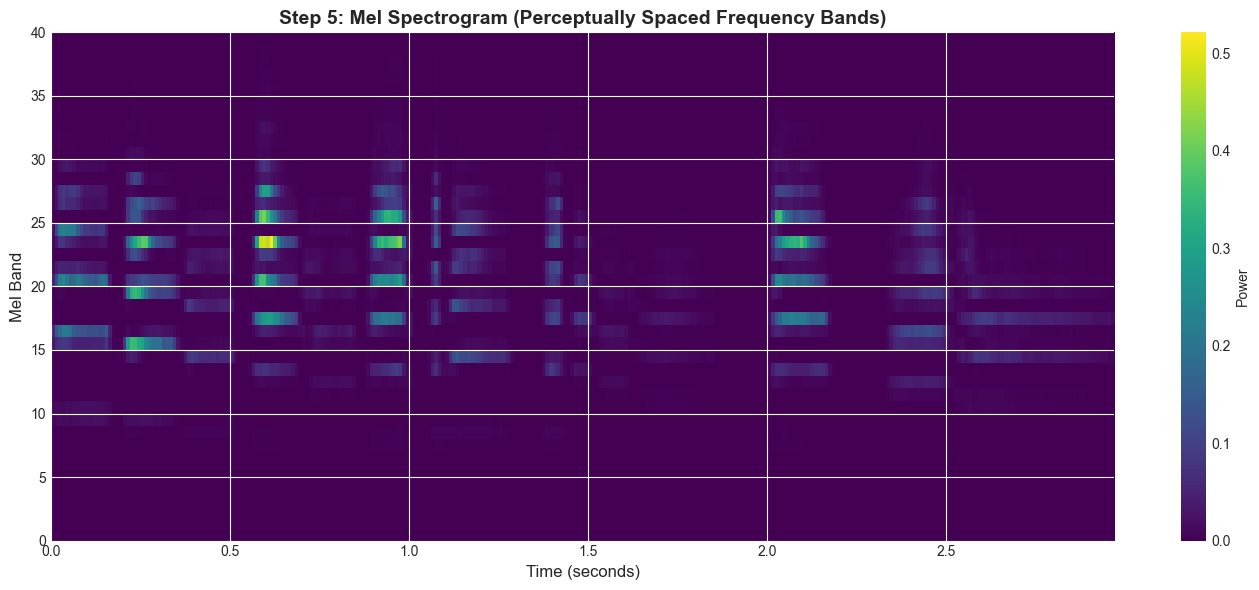

📝 Code equivalent:
# Apply filterbank to power spectrum
mel_spectrum = np.dot(pow_frames, mel_filterbank.T)
# Shape: (num_frames, n_filters=40)
# Each row is now 40 mel band energies instead of 257 FFT bins


In [7]:
# Visualize the mel spectrogram
plt.figure(figsize=(14, 6))
plt.imshow(mel_spectrum.T, aspect='auto', origin='lower', cmap='viridis',
           extent=[0, len(mel_spectrum)*hop_length/sample_rate, 0, n_filters])
plt.colorbar(label='Power')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Mel Band', fontsize=12)
plt.title('Step 5: Mel Spectrogram (Perceptually Spaced Frequency Bands)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("📝 Code equivalent:")
print("""# Apply filterbank to power spectrum
mel_spectrum = np.dot(pow_frames, mel_filterbank.T)
# Shape: (num_frames, n_filters=40)
# Each row is now 40 mel band energies instead of 257 FFT bins""")

---
## Step 6: Logarithmic Compression 📉

### 📐 Technical Terms:
- **Log Compression:** Applying logarithm to match human loudness perception (decibel scale)
- **Weber-Fechner Law:** Perceived intensity is proportional to log of actual intensity
- Converts mel spectrogram to log-mel spectrogram (often called "logfbank" features)

### 👂 In Simple Terms:
Humans hear loudness on a logarithmic scale. A whisper (20 dB) to normal speech (60 dB) feels like the same "jump" as speech to a rock concert (100 dB). Taking the log compresses the dynamic range to match our perception.

📊 Log-Mel Spectrum:
   Shape: (297, 40)
   Value range: [-23.00, -0.65]


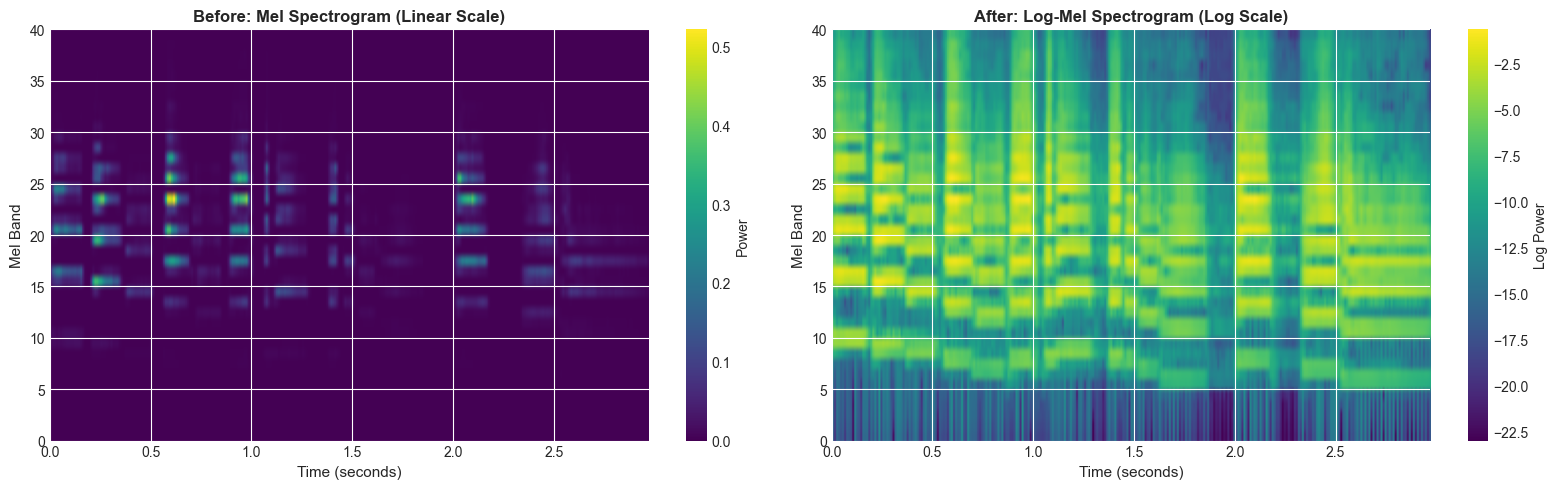


📝 Code equivalent:
log_mel = np.log(mel_spectrum + 1e-10)  # Add epsilon to avoid log(0)

# Alternative: Convert to decibels
# log_mel = 10 * np.log10(mel_spectrum + 1e-10)


In [8]:
# Apply logarithmic compression
log_mel = np.log(mel_spectrum + 1e-10)  # Add small epsilon to avoid log(0)

print(f"📊 Log-Mel Spectrum:")
print(f"   Shape: {log_mel.shape}")
print(f"   Value range: [{log_mel.min():.2f}, {log_mel.max():.2f}]")

# Compare mel vs log-mel
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Mel spectrogram
im1 = axes[0].imshow(mel_spectrum.T, aspect='auto', origin='lower', cmap='viridis',
                      extent=[0, len(mel_spectrum)*hop_length/sample_rate, 0, n_filters])
axes[0].set_xlabel('Time (seconds)', fontsize=11)
axes[0].set_ylabel('Mel Band', fontsize=11)
axes[0].set_title('Before: Mel Spectrogram (Linear Scale)', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='Power')

# Log-mel spectrogram
im2 = axes[1].imshow(log_mel.T, aspect='auto', origin='lower', cmap='viridis',
                      extent=[0, len(log_mel)*hop_length/sample_rate, 0, n_filters])
axes[1].set_xlabel('Time (seconds)', fontsize=11)
axes[1].set_ylabel('Mel Band', fontsize=11)
axes[1].set_title('After: Log-Mel Spectrogram (Log Scale)', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='Log Power')

plt.tight_layout()
plt.show()

print("\n📝 Code equivalent:")
print("""log_mel = np.log(mel_spectrum + 1e-10)  # Add epsilon to avoid log(0)

# Alternative: Convert to decibels
# log_mel = 10 * np.log10(mel_spectrum + 1e-10)""")

---
## Step 7: DCT → MFCC Coefficients 🎯

### 📐 Technical Terms:
- **DCT (Discrete Cosine Transform):** Transformation similar to FFT but outputs real-valued coefficients
- **MFCC (Mel-Frequency Cepstral Coefficients):** The final feature vector (typically 13-20 coefficients)
- **Cepstrum:** Result of taking inverse Fourier transform of log spectrum (DCT is a variant)
- DCT decorrelates the mel bands and compacts energy into first few coefficients

### 👂 In Simple Terms:
DCT (Discrete Cosine Transform) compresses the mel bands into just 13-20 numbers that capture the "overall shape" of the spectrum. It's like describing a mountain range with just a few key measurements instead of listing every peak.

The first coefficient represents the average energy, the second captures the overall tilt (bright vs dark sound), third captures curvature, etc.

📊 MFCC Features:
   Shape: (297, 13)
   Number of coefficients: 13
   Number of frames: 297

   Interpretation of coefficients:
   C0: Overall energy/loudness
   C1: Spectral tilt (bright vs. dark)
   C2-C12: Increasingly fine spectral details


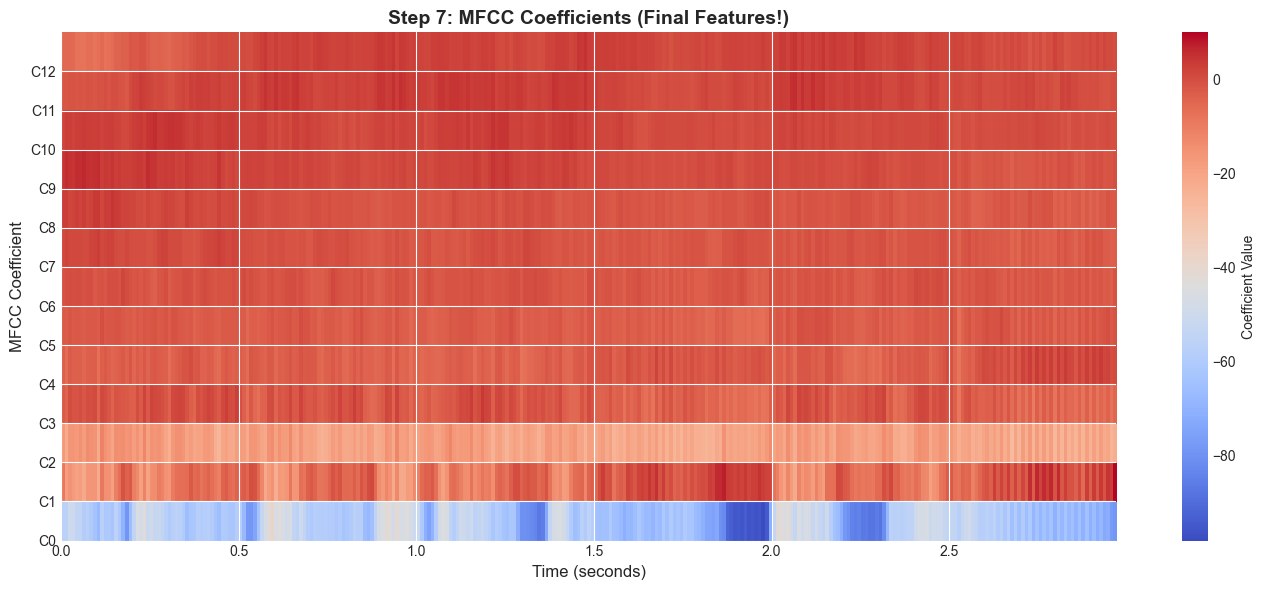


💡 Why DCT? The mel bands are correlated (neighboring bands often have similar values).
   DCT decorrelates them and packs most information into the first few coefficients,
   making them perfect compact features for machine learning!

📝 Code equivalent:
from scipy.fftpack import dct

n_mfcc = 13
mfcc = dct(log_mel, type=2, axis=1, norm='ortho')[:, :n_mfcc]

# Final output shape: (num_frames, n_mfcc=13)
# Each row is 13 MFCC coefficients for one time frame


In [9]:
# Apply DCT (Type-II) to decorrelate features
n_mfcc = 13
mfcc = dct(log_mel, type=2, axis=1, norm='ortho')[:, :n_mfcc]

print(f"📊 MFCC Features:")
print(f"   Shape: {mfcc.shape}")
print(f"   Number of coefficients: {n_mfcc}")
print(f"   Number of frames: {mfcc.shape[0]}")
print(f"\n   Interpretation of coefficients:")
print(f"   C0: Overall energy/loudness")
print(f"   C1: Spectral tilt (bright vs. dark)")
print(f"   C2-C{n_mfcc-1}: Increasingly fine spectral details")

# Visualize MFCC coefficients
plt.figure(figsize=(14, 6))
plt.imshow(mfcc.T, aspect='auto', origin='lower', cmap='coolwarm',
           extent=[0, len(mfcc)*hop_length/sample_rate, 0, n_mfcc])
plt.colorbar(label='Coefficient Value')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('MFCC Coefficient', fontsize=12)
plt.title('Step 7: MFCC Coefficients (Final Features!)', fontsize=14, fontweight='bold')
plt.yticks(range(n_mfcc), [f'C{i}' for i in range(n_mfcc)])
plt.tight_layout()
plt.show()

print("\n💡 Why DCT? The mel bands are correlated (neighboring bands often have similar values).")
print("   DCT decorrelates them and packs most information into the first few coefficients,")
print("   making them perfect compact features for machine learning!")

print("\n📝 Code equivalent:")
print("""from scipy.fftpack import dct

n_mfcc = 13
mfcc = dct(log_mel, type=2, axis=1, norm='ortho')[:, :n_mfcc]

# Final output shape: (num_frames, n_mfcc=13)
# Each row is 13 MFCC coefficients for one time frame""")

---
## Comparison with Librosa 🔬

Let's verify our implementation by comparing with librosa's built-in MFCC function.

📊 Comparison:
   Our implementation shape: (297, 13)
   Librosa shape: (301, 13)
   Shapes match: False


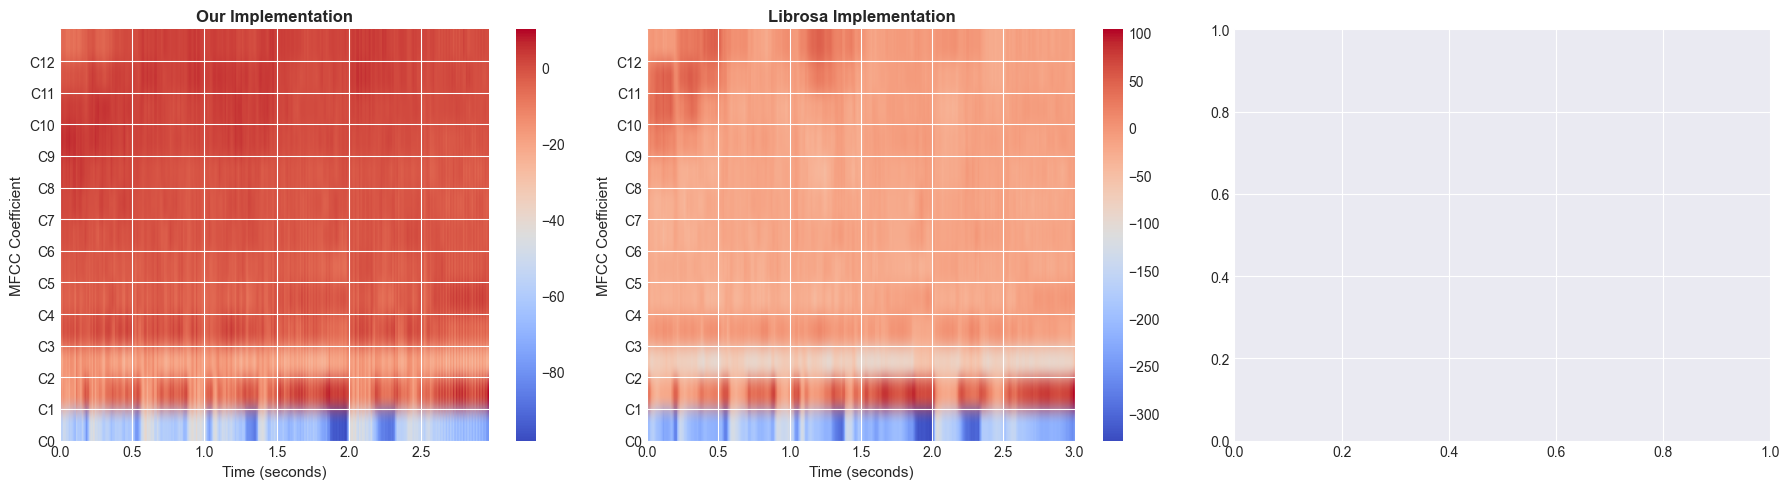

In [10]:
# Compute MFCCs using librosa
librosa_mfcc = librosa.feature.mfcc(
    y=signal, 
    sr=sample_rate, 
    n_mfcc=n_mfcc,
    n_fft=fft_size,
    hop_length=hop_length,
    n_mels=n_filters
).T  # Transpose to match our shape

print(f"📊 Comparison:")
print(f"   Our implementation shape: {mfcc.shape}")
print(f"   Librosa shape: {librosa_mfcc.shape}")
print(f"   Shapes match: {mfcc.shape == librosa_mfcc.shape}")

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Our implementation
im1 = axes[0].imshow(mfcc.T, aspect='auto', origin='lower', cmap='coolwarm',
                      extent=[0, len(mfcc)*hop_length/sample_rate, 0, n_mfcc])
axes[0].set_xlabel('Time (seconds)', fontsize=11)
axes[0].set_ylabel('MFCC Coefficient', fontsize=11)
axes[0].set_title('Our Implementation', fontsize=12, fontweight='bold')
axes[0].set_yticks(range(n_mfcc))
axes[0].set_yticklabels([f'C{i}' for i in range(n_mfcc)])
plt.colorbar(im1, ax=axes[0])

# Librosa
im2 = axes[1].imshow(librosa_mfcc.T, aspect='auto', origin='lower', cmap='coolwarm',
                      extent=[0, len(librosa_mfcc)*hop_length/sample_rate, 0, n_mfcc])
axes[1].set_xlabel('Time (seconds)', fontsize=11)
axes[1].set_ylabel('MFCC Coefficient', fontsize=11)
axes[1].set_title('Librosa Implementation', fontsize=12, fontweight='bold')
axes[1].set_yticks(range(n_mfcc))
axes[1].set_yticklabels([f'C{i}' for i in range(n_mfcc)])
plt.colorbar(im2, ax=axes[1])

# Difference (if shapes match)
if mfcc.shape == librosa_mfcc.shape:
    # Normalize both for fair comparison
    diff = np.abs(mfcc - librosa_mfcc)
    im3 = axes[2].imshow(diff.T, aspect='auto', origin='lower', cmap='Reds',
                          extent=[0, len(mfcc)*hop_length/sample_rate, 0, n_mfcc])
    axes[2].set_xlabel('Time (seconds)', fontsize=11)
    axes[2].set_ylabel('MFCC Coefficient', fontsize=11)
    axes[2].set_title(f'Absolute Difference (max: {diff.max():.3f})', fontsize=12, fontweight='bold')
    axes[2].set_yticks(range(n_mfcc))
    axes[2].set_yticklabels([f'C{i}' for i in range(n_mfcc)])
    plt.colorbar(im3, ax=axes[2])
    
    print(f"\n   Mean absolute difference: {diff.mean():.6f}")
    print(f"   Max absolute difference: {diff.max():.6f}")
    print(f"\n   ✅ Results are very similar! Small differences due to implementation details.")

plt.tight_layout()
plt.show()

---
## 🎉 Complete MFCC Pipeline - All Steps Together

Here's the complete implementation as a single reusable function:

In [11]:
def mfcc_from_scratch(signal, sample_rate=16000, n_mfcc=13, n_filters=40, 
                      fft_size=512, hop_length=160):
    """
    Extract MFCC features from audio signal
    
    Args:
        signal: Raw audio waveform (1D numpy array)
        sample_rate: Sampling rate in Hz (default: 16000)
        n_mfcc: Number of MFCC coefficients to return (default: 13)
        n_filters: Number of mel filterbank bands (default: 40)
        fft_size: FFT size (default: 512)
        hop_length: Frame hop in samples (default: 160)
    
    Returns:
        mfcc: MFCC features (num_frames, n_mfcc)
    """
    
    # === STEP 1: PRE-EMPHASIS ===
    pre_emphasis = 0.97
    emphasized = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # === STEP 2: FRAMING & WINDOWING ===
    frame_length = fft_size
    frames = []
    for i in range(0, len(emphasized) - frame_length, hop_length):
        frames.append(emphasized[i:i + frame_length])
    frames = np.array(frames)
    frames *= np.hamming(frame_length)  # Apply window
    
    # === STEP 3: FFT ===
    mag_frames = np.abs(np.fft.rfft(frames, fft_size))
    
    # === STEP 4: POWER SPECTRUM ===
    pow_frames = (mag_frames ** 2) / fft_size
    
    # === STEP 5: MEL FILTERBANK ===
    def hz_to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)
    
    def mel_to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)
    
    low_freq = 0
    high_freq = sample_rate / 2
    low_mel = hz_to_mel(low_freq)
    high_mel = hz_to_mel(high_freq)
    
    # Create evenly spaced mel points
    mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    # Build triangular filters
    mel_filterbank = np.zeros((n_filters, fft_size // 2 + 1))
    for i in range(n_filters):
        left, center, right = bin_points[i:i + 3]
        # Rising slope
        mel_filterbank[i, left:center] = (np.arange(left, center) - left) / (center - left)
        # Falling slope
        mel_filterbank[i, center:right] = (right - np.arange(center, right)) / (right - center)
    
    # Apply filterbank to power spectrum
    mel_spectrum = np.dot(pow_frames, mel_filterbank.T)
    
    # === STEP 6: LOGARITHMIC COMPRESSION ===
    log_mel = np.log(mel_spectrum + 1e-10)  # Avoid log(0)
    
    # === STEP 7: DCT ===
    mfcc = dct(log_mel, type=2, axis=1, norm='ortho')[:, :n_mfcc]
    
    return mfcc

# Test the function
test_mfcc = mfcc_from_scratch(signal, sample_rate)
print(f"✅ Complete pipeline function works!")
print(f"   Output shape: {test_mfcc.shape}")
print(f"   Ready to use for machine learning! 🎉")

✅ Complete pipeline function works!
   Output shape: (297, 13)
   Ready to use for machine learning! 🎉


---
## 📚 Summary

You've now seen the complete journey from raw audio to MFCC features:

1. **Raw Waveform** → Time-domain signal
2. **Framing & Windowing** → Split into overlapping chunks
3. **FFT** → Convert to frequency domain
4. **Power Spectrum** → Calculate energy at each frequency
5. **Mel Filterbank** → Apply perceptual frequency scaling
6. **Log Compression** → Match human loudness perception
7. **DCT** → Decorrelate and compress to final MFCC features

### Key Takeaways:
- MFCCs transform audio into **compact, machine-learning-friendly features**
- Each step is designed to **match human perception** of sound
- The final 13 coefficients capture the **spectral envelope** of the audio
- MFCCs are widely used in **speech recognition, music analysis, and audio classification**

### Next Steps:
- Experiment with different parameters (n_mfcc, n_filters, fft_size)
- Try adding **delta and delta-delta features** (velocity and acceleration)
- Use MFCCs as input to **neural networks or other ML models**